In [1]:
%cd ..

/home/jairo/Documentos/GitHub/parallel-kink-scattering


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from modules.numeric import *
# from findiff import FinDiff

from modules.plotting import *
cmap = get_cmap()

# Using convolution for apply reflective boundary conditions

In [3]:
from scipy.ndimage import convolve, convolve1d

## Measuring and comparing the methods delay

In [5]:
C = diff_coeffs(2, (-2, -1, 0, 1, 2))
C

array([-0.08333333,  1.33333333, -2.5       ,  1.33333333, -0.08333333])

In [6]:
N = 1000
y = np.random.rand(N)

In [7]:
M = np.r_[[
    np.pad(C, (i, N-i-len(C)))
    for i in range(N-len(C)+1)
]]
M.shape

(996, 1000)

In [8]:
from matplotlib import colors

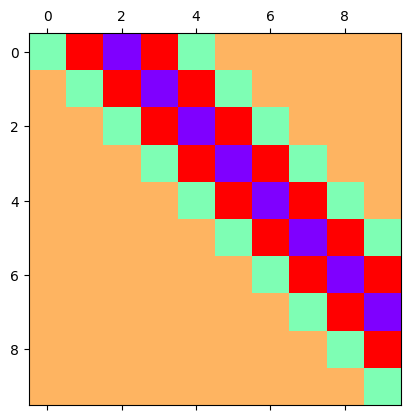

In [9]:
plt.matshow(M[:10, :10], norm=colors.BoundaryNorm(np.sort(np.r_[C, 0]), plt.get_cmap().N), cmap='rainbow')

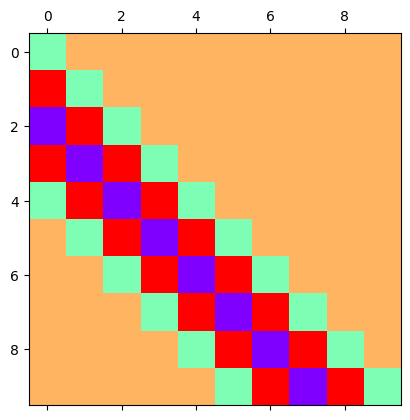

In [10]:
plt.matshow(M[-10:, -10:], norm=colors.BoundaryNorm(np.sort(np.r_[C, 0]), plt.get_cmap().N), cmap='rainbow')

In [14]:
from time import time

In [15]:
t_dot = []
t_conv = []
t_conv1d = []

Ns = np.arange(100, 5000, 50)
for i, N in enumerate(Ns):
    M = np.r_[[
        np.pad(C, (i, N-i-len(C)))
        for i in range(N-len(C)+1)
    ]]
    y = np.random.rand(N)

    m_dot = []
    m_conv = []
    m_conv1d = []
    for _ in range(50):
        tic = time()
        M.dot(y)
        tac = time()
        m_dot.append(tac-tic)

        tic = time()
        convolve(y, C, mode='reflect')
        tac = time()
        m_conv.append(tac-tic)

        tic = time()
        convolve1d(y, C, mode='reflect')
        tac = time()
        m_conv1d.append(tac-tic)

    t_dot.append((np.mean(m_dot), np.std(m_dot)))
    t_conv.append((np.mean(m_conv), np.std(m_conv)))
    t_conv1d.append((np.mean(m_conv1d), np.std(m_conv1d)))

t_dot = np.r_[t_dot]
t_conv = np.r_[t_conv]
t_conv1d = np.r_[t_conv1d]

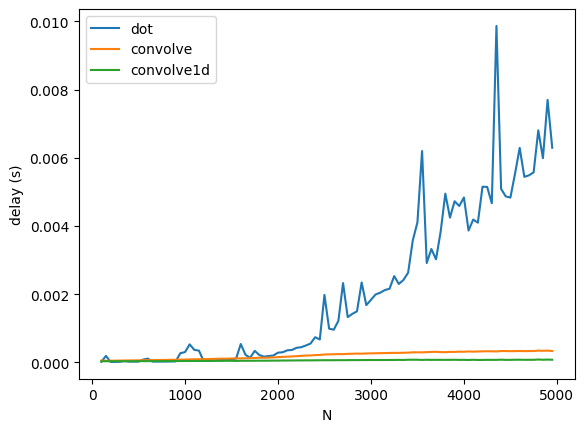

In [16]:
plt.plot(Ns, t_dot[:, 0], label='dot')
plt.plot(Ns, t_conv[:, 0], label='convolve')
plt.plot(Ns, t_conv1d[:, 0], label='convolve1d')
plt.legend()
plt.xlabel('N')
plt.ylabel('delay (s)')
plt.show()

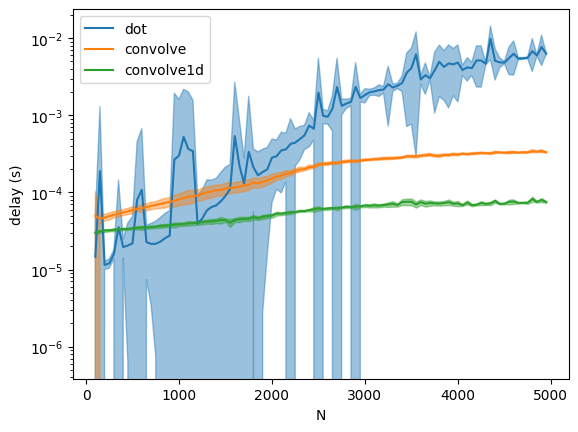

In [17]:
plt.plot(Ns, t_dot[:, 0], label='dot')
plt.plot(Ns, t_conv[:, 0], label='convolve')
plt.plot(Ns, t_conv1d[:, 0], label='convolve1d')
plt.fill_between(Ns, t_dot[:, 0] - t_dot[:, 1], t_dot[:, 0] + t_dot[:, 1], color='C0', alpha=0.45)
plt.fill_between(Ns, t_conv[:, 0] - t_conv[:, 1], t_conv[:, 0] + t_conv[:, 1], color='C1', alpha=0.45)
plt.fill_between(Ns, t_conv1d[:, 0] - t_conv1d[:, 1], t_conv1d[:, 0] + t_conv1d[:, 1], color='C2', alpha=0.45)
plt.semilogy()
plt.legend()
plt.xlabel('N')
plt.ylabel('delay (s)')
plt.show()

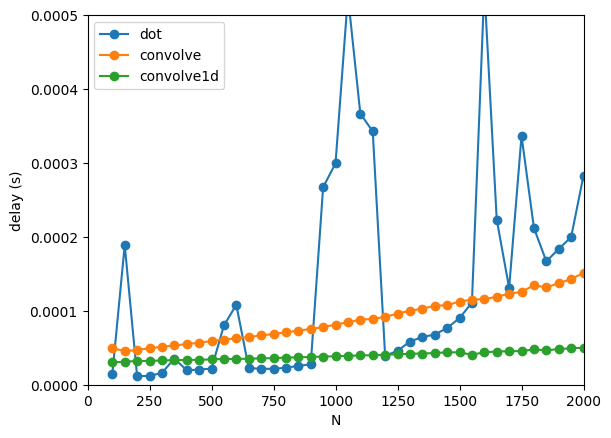

In [18]:
plt.plot(Ns, t_dot[:, 0], '-o', label='dot')
plt.plot(Ns, t_conv[:, 0], '-o', label='convolve')
plt.plot(Ns, t_conv1d[:, 0], '-o', label='convolve1d')
plt.legend()
plt.xlabel('N')
plt.ylabel('delay (s)')
plt.ylim(0, 0.0005)
plt.xlim(0, 2000)
plt.show()

## Testing

In [8]:
L = 50
N = 1000
dx = 2*L/N
dt = 0.7*dx
x_range = (-L, L, dx)

In [9]:
order = 4
x = np.arange(*x_range)
p = order + 2
D2x = diff_coeffs(2, np.arange(p) - p//2, h=x_range[-1])
def F(t, Y, lamb):
    y, dy_dt = Y
    return np.stack((
        dy_dt, # = dy(t)
        convolve1d(y, D2x, mode='reflect') + lamb*y*(1 - y**2) # = ddy(t)
    ))

In [6]:
lamb = 1
x0 = 10*Kink.delta(lamb)/2

collider = KinkCollider(x_range, x0s=(-x0, x0), dt=dt, order=4)
collider.F = F

In [7]:
v = 0.1923
lat, Y = collider.collide(vs=(v, -v), lamb=lamb, t_final=x0/v + 2*L)

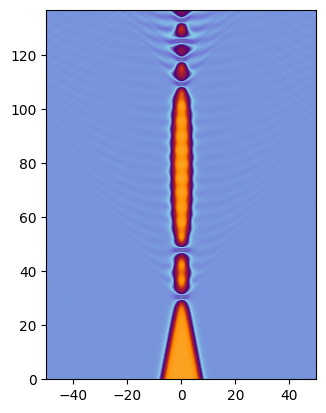

In [8]:
plt.imshow(Y[:, 0], extent=(lat.x.min(), lat.x.max(), lat.t.min(), lat.t.max()), cmap=cmap, vmin=-2, vmax=2, origin='lower')
plt.show()

In [54]:
def get_y0(x, v, H, x0=-10):
    gamma = 1/np.sqrt(1 - v**2)
    if H > 0:
        X0 = np.arccosh(1/np.sqrt(np.abs(H)))
        y1 = np.tanh(x - X0)
        y0 = y1 - np.tanh(gamma*(x - x0)) + 1
    else:
        X1 = np.arcsinh(1/np.sqrt(np.abs(H)))
        y3 = -1/np.tanh(x - X1)
        y0 = -y3 - np.tanh(gamma*(x - x0)) + 1
    return np.stack((
        y0,
        gamma*v/np.cosh(gamma*(x - x0))**2
    ))

L = 100
N = 1024
dx = L/(N-1)
dt = 0.04

In [72]:
order = 6
p = order + 2
D2x = diff_coeffs(2, np.arange(p) - p//2, h=dx)
def F(t, Y, lamb):
    y, dy_dt = Y
    return np.stack((
        dy_dt, # = dy(t)
        convolve1d(y, D2x, mode='reflect') + lamb*y*(1 - y**2) # = ddy(t)
    ))

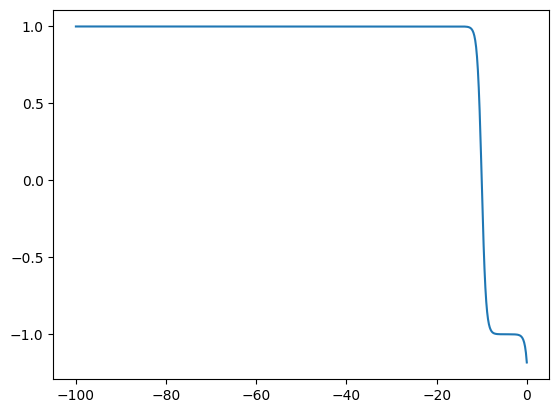

In [73]:
x0 = -10
v = 0.333
H = -0.4

x = np.linspace(-L, 0, N)
y0 = get_y0(x, v, H, x0)
plt.plot(x, y0[0])

In [74]:
t, Y = rk4_solve(partial(F, lamb=2), y0, dt, t_final=2*L)

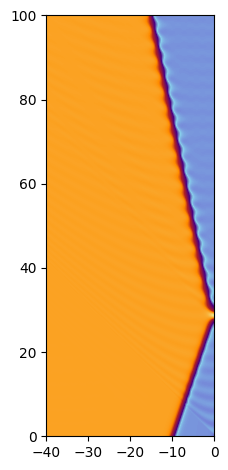

In [75]:
plt.imshow(Y[:, 0], cmap=cmap, vmin=-2, vmax=2, extent=(x.min(), x.max(), t.min(), t.max()), origin='lower')
plt.xlim(-40, 0)
plt.ylim(0, 100)
plt.gcf().tight_layout()